In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, multilabel_confusion_matrix, roc_curve, auc

In [3]:
df = pd.read_csv("winequality-red.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Train test

In [4]:
X = df.drop(columns=["quality"])
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1279, 11)
(1279,)
(320, 11)
(320,)


## Logistic Regresion multiclase

In [5]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)


c:\Users\Itxaso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [6]:
pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))

Accuracy: 0.5875


## Logistic Regression Multiclase con GridSearchCV

In [7]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500))
])

param_grid = {"logreg__C": [0.1, 1, 3, 5, 10]}

grid = GridSearchCV(pipe,param_grid,cv=5,scoring="accuracy",n_jobs=-1)

grid.fit(X_train, y_train)

print("Mejor parámetro:", grid.best_params_)
print("Mejor score:", grid.best_score_)

Mejor parámetro: {'logreg__C': 0.1}
Mejor score: 0.599656862745098


In [8]:
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_test)

print("Accuracy Test (Logistic GS):", accuracy_score(y_test, y_pred_log))

Accuracy Test (Logistic GS): 0.565625


### RandomForest

In [9]:
rf = RandomForestClassifier(n_estimators=300,max_depth=None,random_state=11)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Accuracy Test (RF):", accuracy_score(y_test, y_pred_rf))

Accuracy Test (RF): 0.66875


### XGBoost

In [28]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=11, stratify=y_encoded)

In [30]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_encoded)),
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


Accuracy: 0.684375


In [31]:
pred_original = le.inverse_transform(y_pred_xgb)

## Adaboost

In [35]:
ada = AdaBoostClassifier(
    n_estimators=300,
    learning_rate=0.5,
    random_state=11
)

ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

print("Accuracy AdaBoost:", accuracy_score(y_test, y_pred_ada))


Accuracy AdaBoost: 0.546875


## Gradientboost

In [38]:
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Accuracy GradientBoost:", accuracy_score(y_test, y_pred_gb))


Accuracy GradientBoost: 0.6375


### Aplico un GrindSearch y un RandomizedSearch a mi mejor modelo (XGBoost)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits

=================== TABLA COMPARATIVA ===================
Accuracy GridSearch:      0.6531
Accuracy RandomSearch:    0.6531


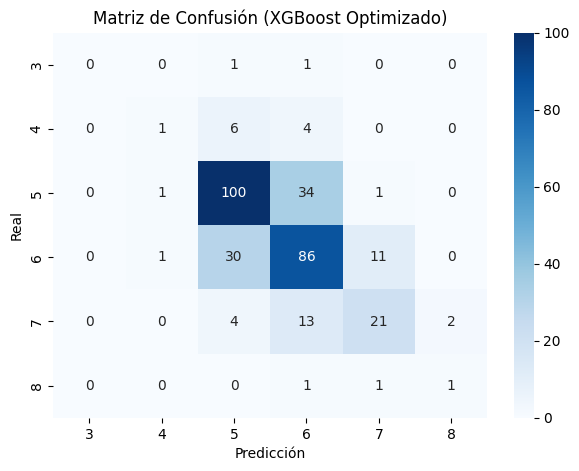

C:\Users\Itxaso\AppData\Local\Temp\ipykernel_14348\143565063.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx], y=X.columns[sorted_idx], palette="viridis")


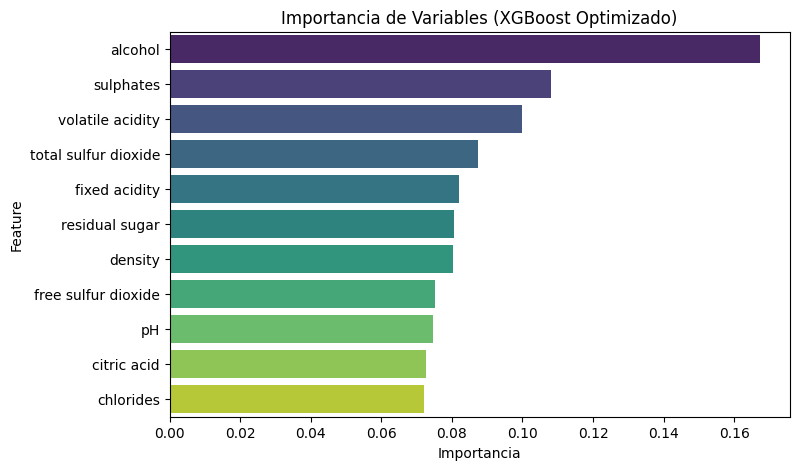

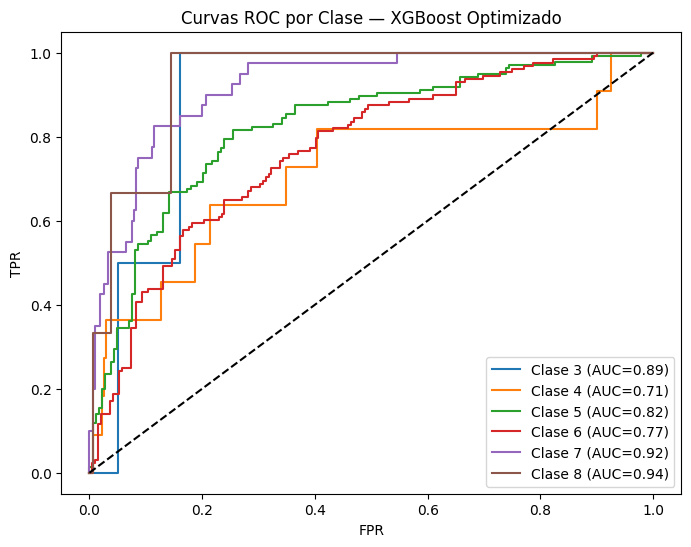


Ejemplo de predicciones (clase original): [7 6 5 6 5 7 6 5 5 8]


In [45]:
le = LabelEncoder()
y_encoded = le.fit_transform(df["quality"])
X = df.drop(columns=["quality"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42
)


param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400, 600],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_xgb_grid = grid.best_estimator_
y_pred_grid = best_xgb_grid.predict(X_test)


param_dist = {
    "max_depth": np.arange(3, 12),
    "learning_rate": np.linspace(0.01, 0.2, 20),
    "n_estimators": np.arange(200, 1001, 50),
    "subsample": np.linspace(0.6, 1.0, 5),
    "colsample_bytree": np.linspace(0.6, 1.0, 5),
    "gamma": np.linspace(0, 5, 6),
    "min_child_weight": np.arange(1, 10)
}

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring="accuracy",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_xgb_random = random_search.best_estimator_
y_pred_random = best_xgb_random.predict(X_test)



print("\n=================== TABLA COMPARATIVA ===================")
print(f"Accuracy GridSearch:      {accuracy_score(y_test, y_pred_grid):.4f}")
print(f"Accuracy RandomSearch:    {accuracy_score(y_test, y_pred_random):.4f}")



cm = confusion_matrix(y_test, y_pred_random)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión (XGBoost Optimizado)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()



importances = best_xgb_random.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[sorted_idx], y=X.columns[sorted_idx], palette="viridis")
plt.title("Importancia de Variables (XGBoost Optimizado)")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.show()



y_prob = best_xgb_random.predict_proba(X_test)
n_classes = len(le.classes_)

plt.figure(figsize=(8,6))

for c in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == c, y_prob[:, c])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Clase {le.classes_[c]} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.title("Curvas ROC por Clase — XGBoost Optimizado")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


y_pred_original = le.inverse_transform(y_pred_random)
print("\nEjemplo de predicciones (clase original):", y_pred_original[:10])
